Following example here: https://examples.ionsim.org/tutorial-notebooks/getting_started.html

In [2]:
using QuantumOptics
using IonSim
import PyPlot

const plt = PyPlot;

In [3]:
# Run this cell to test if the LinearChain object is gonna give us a headache.

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  7.940883 seconds (15.11 M allocations: 973.026 MiB, 7.95% gc time, 99.86% compilation time: <1% of which was recompilation)


In [2]:
# # Sanity check
# S = ionprojector(chamber, "S")
# dm(CALCIUM40["S"]) ⊗ one(vibrational_mode) == S

Helper function for plotting

In [263]:
CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
TIMESCALE = 1e-6 
function plot_populations(chamber, tout, sol)
    vibrational_mode = modes(chamber)[1]

    Z_plus = CALCIUM40["S"]
    Z_minus = CALCIUM40["D"]

    X_plus = (Z_plus + Z_minus)/√2
    X_minus = (Z_plus - Z_minus)/√2

    Y_plus = (Z_plus + im*Z_minus)/√2
    Y_minus = (Z_plus - im*Z_minus)/√2

    prob_X_plus = expect(dm(X_plus) ⊗ one(vibrational_mode), sol)
    prob_X_minus = expect(dm(X_minus) ⊗ one(vibrational_mode), sol)
    prob_Y_plus = expect(dm(Y_plus) ⊗ one(vibrational_mode), sol)
    prob_Y_minus = expect(dm(Y_minus) ⊗ one(vibrational_mode), sol)
    prob_Z_plus = expect(dm(Z_plus) ⊗ one(vibrational_mode), sol)
    prob_Z_minus = expect(dm(Z_minus) ⊗ one(vibrational_mode), sol)

    fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
    x_ax.plot(tout, prob_X_plus, label="|X+⟩", linewidth=4)
    x_ax.plot(tout, prob_X_minus, "--", label="|X-⟩", linewidth=4)
    x_ax.set_xlim(tout[1], tout[end])
    x_ax.set_ylim(0, 1)
    x_ax.legend(loc=1)
    x_ax.set_xlabel("Time (μs)")

    y_ax.plot(tout, prob_Y_plus, label="|Y+⟩", linewidth=4)
    y_ax.plot(tout, prob_Y_minus, "--", label="|Y-⟩", linewidth=4)
    y_ax.set_xlim(tout[1], tout[end])
    y_ax.set_ylim(0, 1)
    y_ax.legend(loc=1)
    y_ax.set_xlabel("Time (μs)")

    z_ax.plot(tout, prob_Z_plus, label="|Z+⟩", linewidth=4)
    z_ax.plot(tout, prob_Z_minus, "--", label="|Z-⟩", linewidth=4)
    z_ax.set_xlim(tout[1], tout[end])
    z_ax.set_ylim(0, 1)
    z_ax.legend(loc=1)
    z_ax.set_xlabel("Time (μs)")

    return fig
end

plot_populations (generic function with 1 method)

## 1. Simulate $R_X$ rotations

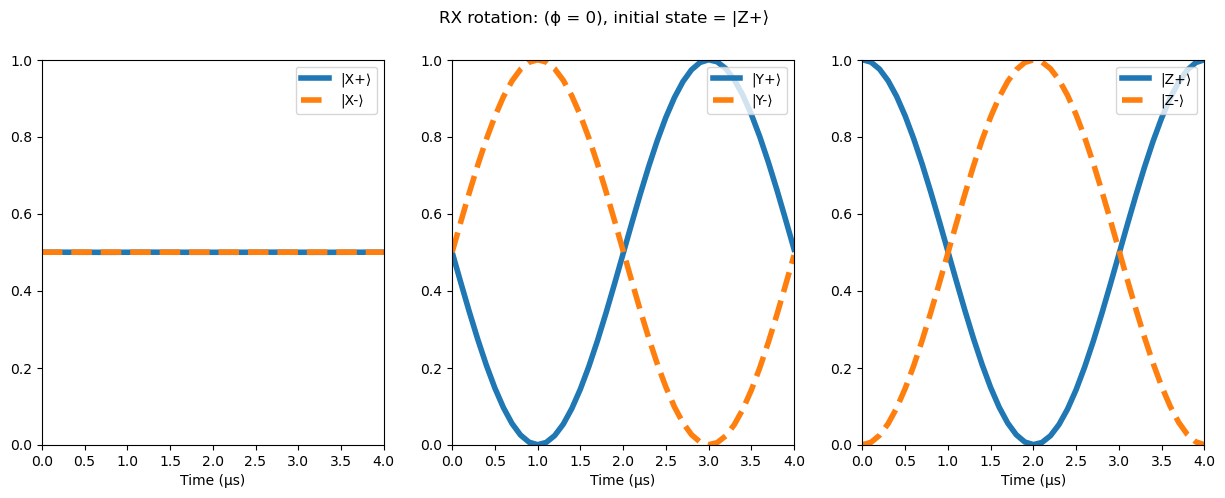

  0.001684 seconds (51.49 k allocations: 2.843 MiB)
  0.001108 seconds (35.16 k allocations: 977.125 KiB)


In [392]:
@time chain = LinearChain(
        ions = [CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = 1e6), 
        selectedmodes = (;z = [1],)
    )

laser = Laser(Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser]);

λ = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(laser, λ)

pitime = 2e-6
I = intensity_from_pitime(laser, pitime, CALCIUM40, ("S", "D"), chamber);
intensity!(laser, I)

# Time-dependent Hamiltonian
h = hamiltonian(chamber, timescale=TIMESCALE);

# Electronic state
ψ0_electronic = CALCIUM40["S"]

# Motional state
vibrational_mode = modes(chamber)[1]
ψ0_motional = vibrational_mode[0] # GLOBAL: ground state of the first vibrational mode

ψ0 = ψ0_electronic ⊗ ψ0_motional # GLOBAL: initial state for all the simulations

# Integration time
t_range = timescale*[0:0.1:4;]
@time tout, ψt = timeevolution.schroedinger_dynamic(t_range/TIMESCALE, ψ0, h);
ψt

fig = plot_populations(chamber, tout, ψt)
fig.suptitle("RX rotation: (ϕ = 0), initial state = |Z+⟩")
plt.display(fig)

## 2. Simulate $R_Y$ rotations

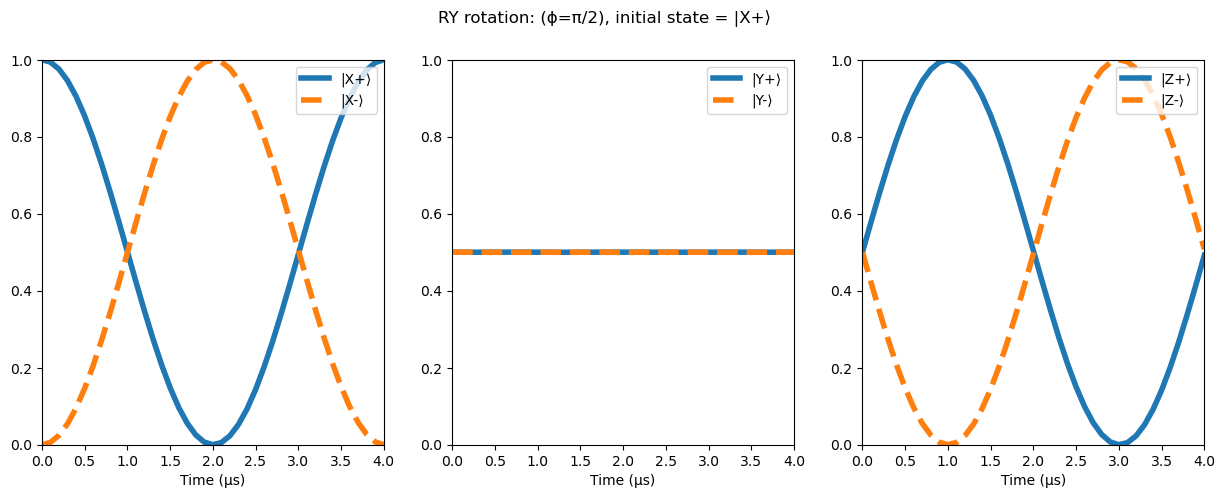

  0.001665 seconds (51.49 k allocations: 2.843 MiB)
  0.000738 seconds (34.28 k allocations: 953.500 KiB)


In [319]:
@time chain = LinearChain(
        ions = [CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = 1e6), 
        selectedmodes = (;z = [1],)
    )

laser = Laser(Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = π/2) # <-- CHANGE = VARY PHASE
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser]);

λ = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(laser, λ)

pitime = 2e-6
I = intensity_from_pitime(laser, pitime, CALCIUM40, ("S", "D"), chamber);
intensity!(laser, I)

# Time-dependent Hamiltonian
h = hamiltonian(chamber, timescale=TIMESCALE);

# Electronic state
#ψ0_electronic = CALCIUM40["S"]
ψ0_electronic = (CALCIUM40["S"] + CALCIUM40["D"])/√2

# Motional state
vibrational_mode = modes(chamber)[1]
ψ0_motional = vibrational_mode[0] # GLOBAL: ground state of the first vibrational mode
ψ0 = ψ0_electronic ⊗ ψ0_motional # GLOBAL: initial state for all the simulations

# Integration time
t_range = timescale*[0:0.1:4;]
@time tout, ψt = timeevolution.schroedinger_dynamic(t_range/TIMESCALE, ψ0, h);
ψt

fig = plot_populations(chamber, tout, ψt)
fig.suptitle("RY rotation: (ϕ=π/2), initial state = |X+⟩")
plt.display(fig)

## 3. Simulate $R_Z$ rotations

$R_Z(\theta) = R_X(\frac{\pi}{2}) R_Y(\theta) R_X(-\pi/2)$

In [545]:
vibrational_mode = modes(chamber)[1]

Z_plus = dm(CALCIUM40["S"]) ⊗ one(vibrational_mode)
Z_minus = dm(CALCIUM40["D"]) ⊗ one(vibrational_mode)
X_plus = dm((CALCIUM40["S"] + CALCIUM40["D"])/√2) ⊗ one(vibrational_mode)
X_minus = dm((CALCIUM40["S"] - CALCIUM40["D"])/√2) ⊗ one(vibrational_mode)
Y_plus = dm((CALCIUM40["S"] + im*CALCIUM40["D"])/√2) ⊗ one(vibrational_mode)
Y_minus = dm((CALCIUM40["S"] - im*CALCIUM40["D"])/√2) ⊗ one(vibrational_mode);

tout = zeros(0)
prob_X_plus = zeros(0)
prob_X_minus = zeros(0)
prob_Y_plus = zeros(0)
prob_Y_minus = zeros(0)
prob_Z_plus = zeros(0)
prob_Z_minus = zeros(0);

In [546]:
@time chain = LinearChain(
        ions = [CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = 1e6), 
        selectedmodes = (;z = [1],)
    )

laser = Laser(Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser]);

λ = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(laser, λ)

pitime = 2e-6
I = intensity_from_pitime(laser, pitime, CALCIUM40, ("S", "D"), chamber);
intensity!(laser, I)

# Initial state
#ψ0_electronic = CALCIUM40["S"]
ψ0_electronic = (CALCIUM40["S"] + CALCIUM40["D"])/√2
vibrational_mode = modes(chamber)[1]
ψ0_motional = vibrational_mode[0] 
ψ0 = ψ0_electronic ⊗ ψ0_motional;


  0.002319 seconds (51.49 k allocations: 2.843 MiB)


### 3.1 $R_X(-\pi/2)$

In [547]:
phase!(laser, 0)
h = hamiltonian(chamber, timescale=TIMESCALE);

# Integration time
t_range = timescale*[0:0.1:4;]*3/4 #*3/4 because -pi/2 rotation
tout_1, ψt_1 = timeevolution.schroedinger_dynamic(t_range/TIMESCALE, ψ0, h);
ψt

tout = vcat(tout, tout_1)
prob_X_plus = vcat(prob_X_plus, expect(X_plus, ψt_1))
prob_X_minus = vcat(prob_X_minus, expect(X_minus, ψt_1))
prob_Y_plus = vcat(prob_Y_plus, expect(Y_plus, ψt_1))
prob_Y_minus = vcat(prob_Y_minus, expect(Y_minus, ψt_1))
prob_Z_plus = vcat(prob_Z_plus, expect(Z_plus, ψt_1))
prob_Z_minus = vcat(prob_Z_minus, expect(Z_minus, ψt_1));


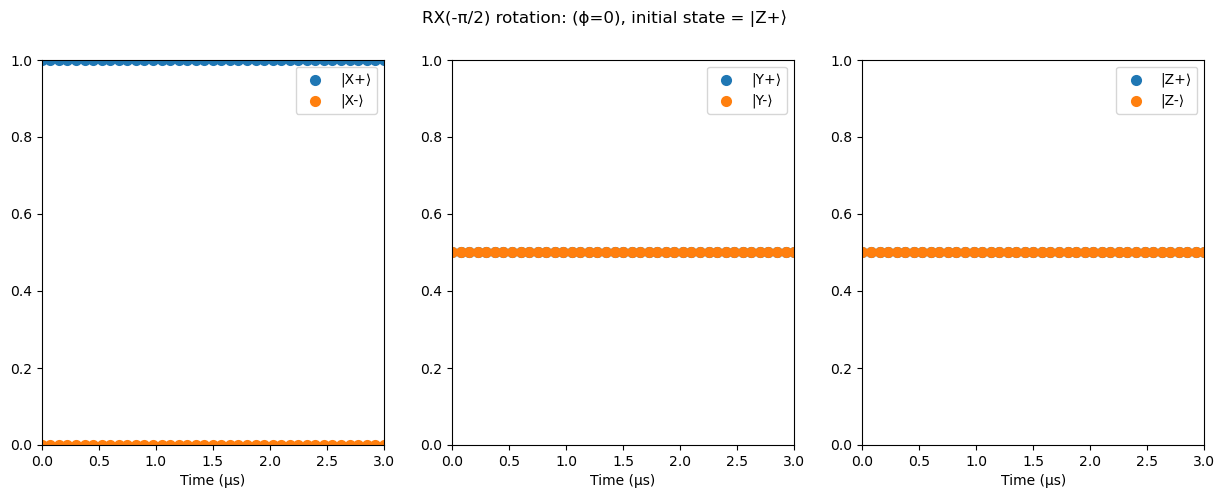

In [548]:
fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
x_ax.scatter(tout, prob_X_plus, label="|X+⟩", linewidth=2)
x_ax.scatter(tout, prob_X_minus, label="|X-⟩", linewidth=2)
x_ax.set_xlim(tout[1], tout[end])
x_ax.set_ylim(0, 1)
x_ax.legend(loc=1)
x_ax.set_xlabel("Time (μs)")

y_ax.scatter(tout, prob_Y_plus, label="|Y+⟩", linewidth=2)
y_ax.scatter(tout, prob_Y_minus, label="|Y-⟩", linewidth=2)
y_ax.set_xlim(tout[1], tout[end])
y_ax.set_ylim(0, 1)
y_ax.legend(loc=1)
y_ax.set_xlabel("Time (μs)")

z_ax.scatter(tout, prob_Z_plus, label="|Z+⟩", linewidth=2)
z_ax.scatter(tout, prob_Z_minus, label="|Z-⟩", linewidth=2)
z_ax.set_xlim(tout[1], tout[end])
z_ax.set_ylim(0, 1)
z_ax.legend(loc=1)
z_ax.set_xlabel("Time (μs)")

fig.suptitle("RX(-π/2) rotation: (ϕ=0), initial state = |Z+⟩")
plt.display(fig)

### 3.2 $R_Y(\theta)$

In our case, $\theta = 2 \pi$

In [549]:
phase!(laser, π/2)
h = hamiltonian(chamber, timescale=TIMESCALE);

# Integration time
t_range = TIMESCALE*([0:0.1:4;]/2 .+ tout[end])
tout_2, ψt_2 = timeevolution.schroedinger_dynamic(t_range/TIMESCALE, ψt_1[end], h);

tout = vcat(tout, tout_2)
prob_X_plus = vcat(prob_X_plus, expect(X_plus, ψt_2))
prob_X_minus = vcat(prob_X_minus, expect(X_minus, ψt_2))
prob_Y_plus = vcat(prob_Y_plus, expect(Y_plus, ψt_2))
prob_Y_minus = vcat(prob_Y_minus, expect(Y_minus, ψt_2))
prob_Z_plus = vcat(prob_Z_plus, expect(Z_plus, ψt_2))
prob_Z_minus = vcat(prob_Z_minus, expect(Z_minus, ψt_2));


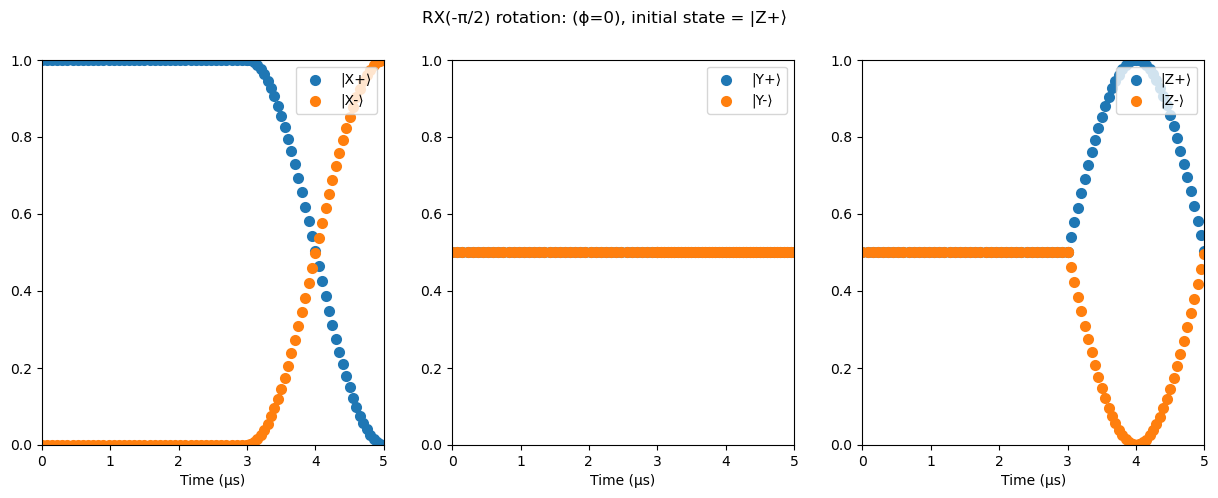

In [550]:
fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
x_ax.scatter(tout, prob_X_plus, label="|X+⟩", linewidth=2)
x_ax.scatter(tout, prob_X_minus, label="|X-⟩", linewidth=2)
x_ax.set_xlim(tout[1], tout[end])
x_ax.set_ylim(0, 1)
x_ax.legend(loc=1)
x_ax.set_xlabel("Time (μs)")

y_ax.scatter(tout, prob_Y_plus, label="|Y+⟩", linewidth=2)
y_ax.scatter(tout, prob_Y_minus, label="|Y-⟩", linewidth=2)
y_ax.set_xlim(tout[1], tout[end])
y_ax.set_ylim(0, 1)
y_ax.legend(loc=1)
y_ax.set_xlabel("Time (μs)")

z_ax.scatter(tout, prob_Z_plus, label="|Z+⟩", linewidth=2)
z_ax.scatter(tout, prob_Z_minus, label="|Z-⟩", linewidth=2)
z_ax.set_xlim(tout[1], tout[end])
z_ax.set_ylim(0, 1)
z_ax.legend(loc=1)
z_ax.set_xlabel("Time (μs)")

fig.suptitle("RX(-π/2) rotation: (ϕ=0), initial state = |Z+⟩")
plt.display(fig)

### 3.3 $R_X(-\pi/2)$

In [551]:
phase!(laser, 0)
h = hamiltonian(chamber, timescale=TIMESCALE);

# Integration time
t_range = TIMESCALE*([0:0.1:4;]/4 .+ tout[end])
tout_3, ψt_3 = timeevolution.schroedinger_dynamic(t_range/TIMESCALE, ψt_2[end], h);
ψt

tout = vcat(tout, tout_3)
prob_X_plus = vcat(prob_X_plus, expect(X_plus, ψt_3))
prob_X_minus = vcat(prob_X_minus, expect(X_minus, ψt_3))
prob_Y_plus = vcat(prob_Y_plus, expect(Y_plus, ψt_3))
prob_Y_minus = vcat(prob_Y_minus, expect(Y_minus, ψt_3))
prob_Z_plus = vcat(prob_Z_plus, expect(Z_plus, ψt_3))
prob_Z_minus = vcat(prob_Z_minus, expect(Z_minus, ψt_3));


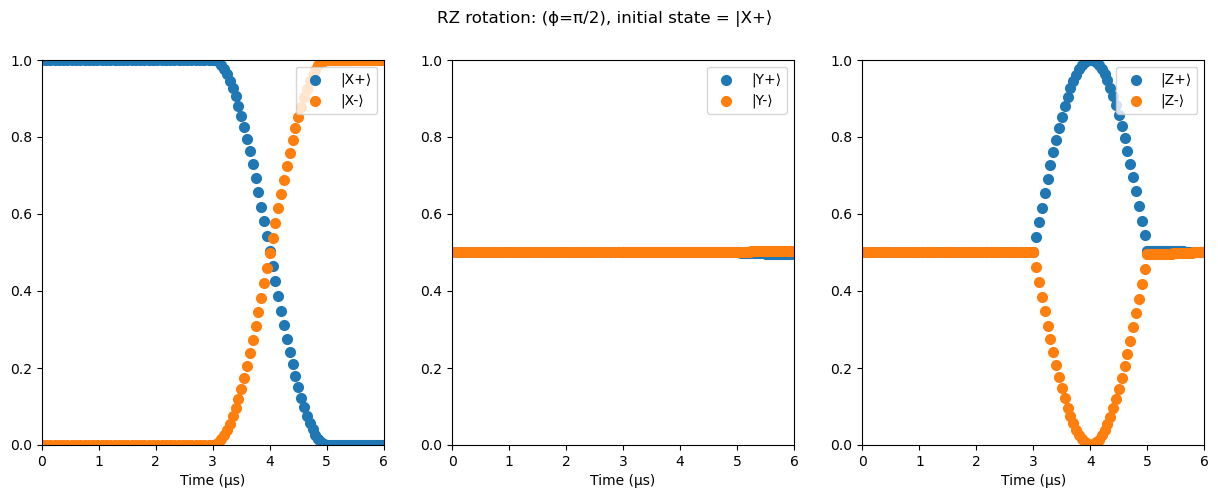

In [553]:
fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
x_ax.scatter(tout, prob_X_plus, label="|X+⟩", linewidth=2)
x_ax.scatter(tout, prob_X_minus, label="|X-⟩", linewidth=2)
x_ax.set_xlim(tout[1], tout[end])
x_ax.set_ylim(0, 1)
x_ax.legend(loc=1)
x_ax.set_xlabel("Time (μs)")

y_ax.scatter(tout, prob_Y_plus, label="|Y+⟩", linewidth=2)
y_ax.scatter(tout, prob_Y_minus, label="|Y-⟩", linewidth=2)
y_ax.set_xlim(tout[1], tout[end])
y_ax.set_ylim(0, 1)
y_ax.legend(loc=1)
y_ax.set_xlabel("Time (μs)")

z_ax.scatter(tout, prob_Z_plus, label="|Z+⟩", linewidth=2)
z_ax.scatter(tout, prob_Z_minus, label="|Z-⟩", linewidth=2)
z_ax.set_xlim(tout[1], tout[end])
z_ax.set_ylim(0, 1)
z_ax.legend(loc=1)
z_ax.set_xlabel("Time (μs)")

fig.suptitle("RZ rotation: (ϕ=π/2), initial state = |X+⟩")
plt.display(fig)